In [2]:
import gzip
import json
import re
import os
import sys
import timeit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display

import sklearn.manifold
import tensorflow as tf
import altair as alt
import collections


from src.load_data import read_tables
from src.CFModel import CFModel, build_CF_model, compute_scores, book_neighbors, user_recommendations
from src.Baseline_Model import build_baseline_model

### load data

In [3]:
# data from Goodreads: reviews and meta data on mystery_thrill_crime books filtered to keep english only books

reviews = pd.read_csv('data/cleaned_reviews_mystery_1.csv')
books = pd.read_csv('data/cleaned_books_mystery_1.csv')
books.sort_values(by='book_id', inplace=True)

In [3]:
print('num of books is %d \nnum of users is %d'%(reviews.book_id.nunique(), reviews.user_id.nunique()))

num of books is 105365 
num of users is 121333


## Models

initially we wanted to use evaluation score: the mean of each user's top 5 recommended books' actual rating

since 85% of the users in test data only have 1 ratings, the evaluation score is almost the same (3.865) no matter recommendations are based on which model. (will delete the score later)

we will use mse as evaluation score considering our dataset is sparse

### baseline model - global mean adjusted by user/book deviation

baseline estimate for r_xi = u + b_x + b_i

u: global mean (overall mean book ratings)

b_x: rating deviation of user x = (avg. rating of user x) - u

b_i: rating deviation of book i = (avg. rating of book i) - u

In [4]:
train_mse_error, test_mse_error, test_rmse_error, test_mae_error, evaluation_score = build_baseline_model(reviews) 
#print out train dataset mean rating to confirm each model uses the same training data

train_data mean rating: 3.80621


/Users/elainewu/Documents/Projects/Assignments/Capstone/Capstone Three/Goodreads_Book_Recommender/src/Baseline_Model.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews['prediction'] = np.zeros(len(reviews))


train mse: 15.53125 
 test_mse: 15.97210, test_rmse: 3.99651, test_mae: 3.86546, 
 evaluation_score: 3.86546


#### always recommend the most popular books

In [5]:
#the books with most reviews in our dataset, which the model will learn these books best
pop_book = reviews.book_id.value_counts()[:10]
pop_book

44449     11373
98973      7906
50968      5698
22647      4054
24807      3997
36873      3970
86372      3806
104081     3346
84502      3292
90886      3103
Name: book_id, dtype: int64

In [5]:
pop_ct_rt = reviews.groupby('book_id').aggregate({'timestamp': 'count', 'rating': 'mean'})

In [8]:
pop_ct_rt.sort_values('timestamp', ascending=False)[:10]

,timestamp,rating
book_id,,
44449,11373,3.6613030862569245
98973,7906,3.8682013660511005
50968,5698,3.8618813618813617
22647,4054,3.8256043413912186
24807,3997,3.5459094320740556
36873,3970,4.305037783375315
86372,3806,3.8878087230688387
104081,3346,3.599521817095039
84502,3292,4.09872417982989


In [ ]:
pop_book_dict = {}
for i in list(pop_book.index):
    pop_book_dict[i] = books[books.book_id == i].title.iloc[0]
pop_book_dict    

In [7]:
# the most popular books per book meta data
books.sort_values('ratings_count', ascending=False)[:10]

,book_id,title,num_pages,is_ebook,link,average_rating,ratings_count,text_reviews_count,author_id,publisher,similar_books,old_book_id
98519,103712,"Angels & Demons (Robert Langdon, #1)",736,0,https://www.goodreads.com/book/show/960.Angels...,3.86,2046499,19683,630,Pocket Books,"['15769', '92147', '1178039', '4312852', '4170...",960
57299,50968,"The Girl with the Dragon Tattoo (Millennium, #1)",465,0,https://www.goodreads.com/book/show/2429135.Th...,4.11,1858152,48632,706255,Knopf,"['3522419', '359126', '39792', '1437993', '714...",2429135
98520,104081,"The Da Vinci Code (Robert Langdon, #2)",481,0,https://www.goodreads.com/book/show/968.The_Da...,3.79,1465770,33535,630,Anchor,"['573202', '1178039', '278210', '198331', '658...",968
87767,44449,The Girl on the Train,323,0,https://www.goodreads.com/book/show/22557272-t...,3.88,1076144,78438,1063732,Riverhead Books,"['2302650', '22535503', '22693182', '20821043'...",22557272
70701,73559,A Time to Kill,515,0,https://www.goodreads.com/book/show/32542.A_Ti...,4.03,604739,3691,721,Delta,"['13148', '15159', '19691', '107483', '4035', ...",32542
80113,36356,Gone Girl,415,0,https://www.goodreads.com/book/show/19288043-g...,4.03,588451,21082,2383,Broadway Books,"['12598982', '13096307', '7093952', '11367726'...",19288043
1584,84502,"The Girl Who Played with Fire (Millennium, #2)",503,0,https://www.goodreads.com/book/show/5060378-th...,4.22,575163,24868,706255,Alfred A. Knopf,"['39801', '13057652', '6304285', '3322382', '1...",5060378
51720,98973,Gone Girl,399,0,https://www.goodreads.com/book/show/8442457-go...,4.03,513361,69096,2383,Weidenfeld & Nicolson,"['12598982', '13096307', '7093952', '11367726'...",8442457
60331,85187,"The Firm (Penguin Readers, Level 5)",75,0,https://www.goodreads.com/book/show/5358.The_Firm,3.99,494812,3173,608211,Addison Wesley Publishing Company,"['425029', '98427', '481372', '32682', '2430',...",5358
73260,104387,Deception Point,556,0,https://www.goodreads.com/book/show/976.Decept...,3.67,464544,6394,630,Pocket Books,"['294047', '5369', '647609', '113138', '19688'...",976


### CF model with adam optimizer

In [34]:
# matrix factorization without regularization with adam optimizer
# adam optimizer -> adaptive moment estimation with changing learning rate 
# https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/

model_adam = build_CF_model(reviews, embedding_dim=30, init_stddev=0.05)

train_data mean rating: 3.80621


 iteration 600: train_error=0.008488842, regularization_error=0.0, test_mse_loss=16.466867, test_rmse_loss=4.057939, test_mae_loss=(3.3826835, 3.3823214)))

[{'train_error': 0.008488842,
  'regularization_error': 0.0,
  'test_mse_loss': 16.466867,
  'test_rmse_loss': 4.057939,
  'test_mae_loss': (3.3826835, 3.3823214)}]

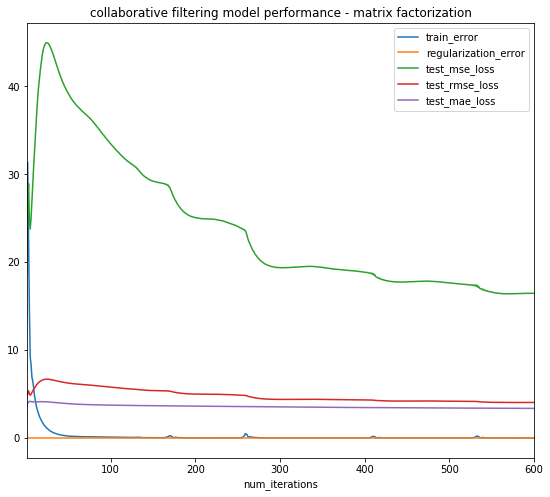

In [35]:
model_adam.train(num_iterations=600)

### CF model with regularization and adam optimizer

In [36]:
# A CFModel object that uses a regularized loss with adam optimizer
model_reg = build_CF_model(reviews, embedding_dim=30, init_stddev=0.05, 
                    regularization_coeff=0.1)

train_data mean rating: 3.80621


 iteration 50: train_error=0.88335544, regularization_error=0.7464846, test_mse_loss=6.2206364, test_rmse_loss=2.4941204, test_mae_loss=(2.5138578, 2.5025713)
time spent for the process is 116.97691 seconds


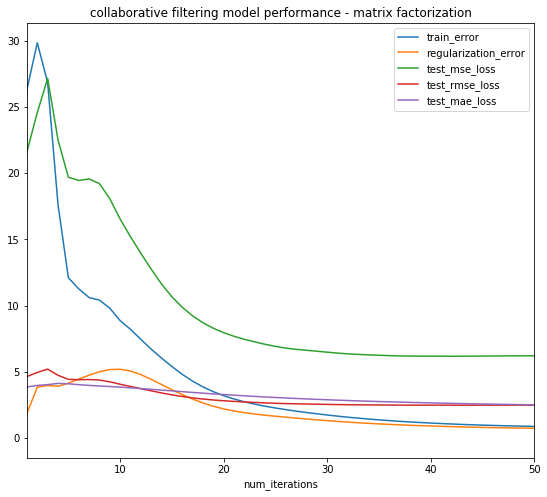

In [37]:
start_time = timeit.default_timer()
model_reg.train(num_iterations=50)

print('\ntime spent for the process is %.5f seconds'% (timeit.default_timer() - start_time))

#### evaluation score is calculated based on  the mean of the top 5% recommended books' actual ratings

since 85% of the users in test data only have 1 ratings, the evaluation score is almost the same (3.865) no matter recommendations are based on which model. (will delete the score later)

In [38]:
# eval_score(test_ratings, model_reg.embeddings['user_id'], model_reg.embeddings['book_id'] )
# 85% of the users in test data only have 1 ratings
# (test_ratings.user_id.value_counts() >1).sum()/len(test_ratings)

In [39]:
# save model_embeddings
np.savez('model/model_reg_embeddings.npz', model_reg.embeddings['user_id'], model_reg.embeddings['book_id'])

# load model_embeddings

# file = np.load('model/model_reg_embeddings.npz')
# user_embeddings = file['arr_0']
# book_embeddings = file['arr_1']

### Explore model_reg performance

#### get recommendations for a given user

In [40]:
#example with user 'd889b42d9eb7b80e02f24830e27c6389'
user_id = 'fca26c34be8fe623ee340061f1281796'
sample_user_pred = user_recommendations(books, reviews, model_reg, user_id, measure='cosine', k=6)

The highest recommendations for user fca26c34be8fe623ee340061f1281796.


In [41]:
sample_user_pred.sort_values('cosine score', ascending=False)[:5]

,cosine score,titles,is_ebook,average_rating,ratings_count,text_reviews_count
50343,0.9281895160675049,"Tonight I Said Goodbye (Lincoln Perry, #1)",0,3.81,72,11
85656,0.9250720143318176,Trial Run,0,3.81,13,3
32979,0.9224690198898315,"Labyrinth (Nameless Detective, #6)",0,4.08,102,14
30636,0.9198542237281799,"Hiding Place (Lt. Hastings, #4)",0,3.45,9,2
6078,0.915286660194397,"Nervous Laughter (Thomas Black, #3)",0,3.88,227,9


In [42]:
# explore the user_prediction (TODO: to delete later)


sample_user_pred = sample_user_pred.reset_index()

sample_user_pred.head()
sample_user_pred.columns = ['old_book_id', 'cosine score', 'titles', 'is_ebook', 'average_rating', 'ratings_count', 'text_reviews_count']

sample_user_actual = reviews[reviews.old_user_id == 'fca26c34be8fe623ee340061f1281796']

for_sample_user_model = sample_user_pred.merge(sample_user_actual, how='left', left_on='old_book_id', right_on = 'old_book_id')

user_df = reviews.groupby('old_user_id').count()['rating']
user_df.head()


old_user_id
00009e46d18f223a82b22da38586b605    15
0000c3d51aa099745e93a4e99c4856c8     4
000192962b87d560f00b06fdcbd71681     2
000253cf1077f203bca050637f2ec7f7     6
00048fe3297cbb92a6e9fb78a6dce421     2
Name: rating, dtype: int64

In [43]:
(user_df.sort_values(ascending=False) > 30).sum()/len(user_df)

0.08478319995384603

### get neighbors of a book which contains a given substring

In [44]:
# use 'The Da Vinci Code' as an example to explore
# the features 'similar_books' means Goodreads members who liked current book also liked
books[books.book_id == 104081] #.similar_books.iloc[0]

,book_id,title,num_pages,is_ebook,link,average_rating,ratings_count,text_reviews_count,author_id,publisher,similar_books,old_book_id,dummy
98520,104081,"The Da Vinci Code (Robert Langdon, #2)",481,0,https://www.goodreads.com/book/show/968.The_Da...,3.79,1465770,33535,630,Anchor,"['573202', '1178039', '278210', '198331', '658...",968,True


In [45]:
similar_book_by_gr = ['573202', '1178039', '278210', '198331', '6588', '14554', '144791', 
                      '294046', '39031', '78971', '5053', '85319', '5355', '238142', '33808']
books[books.old_book_id.isin(similar_book_by_gr)].title

87907         The Venetian Betrayal (Cotton Malone, #3)
17719           Seven Deadly Wonders (Jack West Jr, #1)
60762      If Tomorrow Comes (Tracy Whitney Series, #1)
99372                  Valhalla Rising (Dirk Pitt, #16)
21047                  Visions in Death (In Death, #19)
32828     The Expected One (Magdalene Line Trilogy, #1)
63783                The Judas Strain (Sigma Force, #4)
102348                 The Lion's Game (John Corey, #2)
11717       The Cabinet of Curiosities (Pendergast, #3)
79095                       The Man From St. Petersburg
60325                                       The Chamber
46538              The Matarese Countdown (Matarese #2)
87083                The Big Bad Wolf  (Alex Cross, #9)
82699                                  False Impression
49066                                  The Millionaires
Name: title, dtype: object

In [46]:
book_id = 104081
neighbors_df = book_neighbors(books, reviews, model_reg, book_id, measure='cosine', k=10)
neighbors_df.sort_values(['cosine score'], ascending=False)[:10]

Nearest neighbors of : The Da Vinci Code (Robert Langdon, #2).


,cosine score,book_id,titles,is_ebook,average_rating,ratings_count
98520,1.0,104081,"The Da Vinci Code (Robert Langdon, #2)",0,3.79,1465770
22784,0.8708650469779968,17318,"The Fifth Assassin (Culper Ring, #2)",0,3.8,8973
85528,0.8685855865478516,88142,Trust,0,3.45,62
103850,0.8367718458175659,7685,The Case of the Deadly Butter Chicken (Vish Pu...,0,3.85,2273
16522,0.8300217390060425,36887,Stolen Spirit (PSI Sentinels: Guardians of the...,0,4.15,12
98519,0.8135738372802734,103712,"Angels & Demons (Robert Langdon, #1)",0,3.86,2046499
11128,0.8134526610374451,82311,"See Jane Die (Stacy Killian, #1; The Malones, #2)",0,4.1,5646
43953,0.7981975078582764,12747,The Blasphemer,1,3.54,311
82907,0.7956153154373169,86101,"Abby Cooper, Psychic Eye (Psychic Eye Mystery,...",0,3.91,11406
85145,0.7938860654830933,2526,Agatha Raisin and the Potted Gardener (Agatha ...,0,3.79,6101


In [47]:
# from our review data, check which books are co-rated highly with a given book
def get_top_corated(ratings, books, book_id):
    user_ids = ratings['user_id'][ratings['book_id']==book_id].unique()
    co_ratings = ratings[ratings['user_id'].isin(user_ids)]
    top_books_count = pd.DataFrame(co_ratings['book_id'].value_counts()[:10]).reset_index()
    top_books_count.columns = ['book_id', 'count']                           
    top_books_count = pd.merge(top_books_count, books[['book_id', 'title', 'average_rating']], on='book_id')
    return top_books_count

get_top_corated(reviews, books, 104081)

,book_id,count,title,average_rating
0,104081,3346,"The Da Vinci Code (Robert Langdon, #2)",3.79
1,103712,816,"Angels & Demons (Robert Langdon, #1)",3.86
2,88907,468,"The Lost Symbol (Robert Langdon, #3)",3.66
3,50968,393,"The Girl with the Dragon Tattoo (Millennium, #1)",4.11
4,24807,348,"Inferno (Robert Langdon, #4)",3.81
5,44449,330,The Girl on the Train,3.88
6,98973,251,Gone Girl,4.03
7,104387,233,Deception Point,3.67
8,4280,229,Digital Fortress,3.61
9,84502,207,"The Girl Who Played with Fire (Millennium, #2)",4.22


### inspect neighbor clustering

In [48]:
def book_embedding_norm(books, models):
    """
    visualizes the norm and number of ratings of the book
    Args:
        model: a MFmodel object
    """
    if not isinstance(models, list):
        models = [models]
    df=pd.DataFrame({
        'title': books['title'],
        'average_rating': books['average_rating'],
        'ratings_count':books['ratings_count']
    })
    charts = []
    brush = alt.selection_interval()
    for i, model in enumerate(models):
        norm_key = 'norm' +str(i)
        df[norm_key] = np.linalg.norm(model.embeddings['book_id'], axis=1) #only included the first 1000 books for visualization
        nearest = alt.selection(
                type='single', encodings=['x', 'y'], on='mouseover', nearest=True,
                empty='none')
        base = alt.Chart().mark_circle().encode(
                x='ratings_count',
                y=norm_key,
               color=alt.condition(brush, alt.value('#4c78a8'), alt.value('lightgray'))
            ).properties(selection=nearest).add_selection(brush)
        text = alt.Chart().mark_text(align='center', dx=5, dy=-5).encode(
        x='ratings_count', y=norm_key,
        text=alt.condition(nearest, 'title', alt.value('')))
        charts.append(alt.layer(base, text))
    return alt.hconcat(*charts, data=df[:1000])
    
    

In [49]:

def visualize_book_embeddings(data, x, y):
    nearest = alt.selection(
      type='single', encodings=['x', 'y'], on='mouseover', nearest=True,
      empty='none')
    base = alt.Chart().mark_circle().encode(
      x=x,
      y=y,
      color=alt.condition(dummy_filter, "dummy", alt.value("red")),
      ).properties(
      width=600,
      height=600,
      selection=nearest)
    text = alt.Chart().mark_text(align='left', dx=5, dy=-5).encode(
      x=x,
      y=y,
      text=alt.condition(nearest, 'title', alt.value('')))
    return alt.hconcat(alt.layer(base, text), dummy_chart, data=data)


In [50]:
books['dummy'] = True
dummy_filter = alt.selection_multi(fields=['dummy'])
dummy_chart = alt.Chart().mark_bar().encode(
    x="count()",
    y=alt.Y('dummy'),
    color=alt.condition(
        dummy_filter,
        alt.Color("is_ebook:N"),
        alt.value('lightgray'))
).properties(height=300, selection=dummy_filter)

In [51]:
def tsne_book_embeddings(model_embedding, books):
    """Visualizes the book embeddings, projected using t-SNE with Cosine measure.
    Args:
    model: A MFModel object.
    """
    tsne = sklearn.manifold.TSNE(
      n_components=2, perplexity=40, metric='cosine', early_exaggeration=10.0,
      init='pca', verbose=True, n_iter=400)

    print('Running t-SNE...')
    V_proj = tsne.fit_transform(model_embedding)
    print(V_proj.shape, books.shape)
    books.loc[:,'x'] = V_proj[:, 0]
    books.loc[:,'y'] = V_proj[:, 1]
    return visualize_book_embeddings(books, 'x', 'y')

#### visulize book embedding

In [52]:
import altair as alt
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

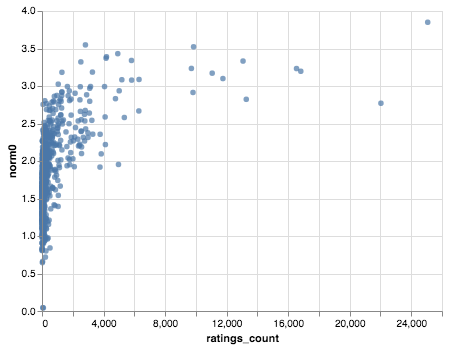

In [53]:
book_embedding_norm(books, model_reg)

#### visualize book clustering

Running t-SNE...
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.000s...
[t-SNE] Computed neighbors for 5000 samples in 0.820s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.143906
[t-SNE] KL divergence after 150 iterations with early exaggeration: 67.554771
[t-SNE] KL divergence after 400 iterations: 3.580974
(5000, 2) (5000, 13)


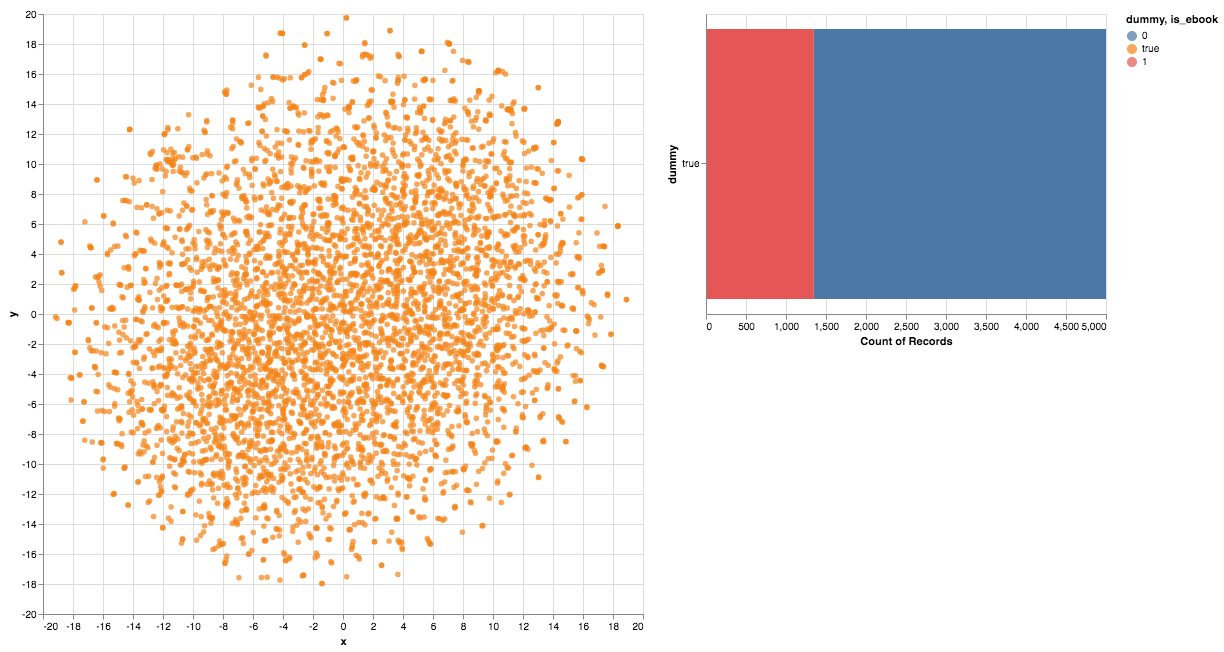

In [54]:
books_vis = books.sort_values(by='book_id')[:5000]
model_book_emb_vis = model_reg.embeddings['book_id'][:5000]
tsne_book_embeddings(model_book_emb_vis, books_vis)

#### visualize the neighbor books recommendation example 'The Da Vinci Code'

Running t-SNE...
[t-SNE] Computing 9 nearest neighbors...
[t-SNE] Indexed 10 samples in 0.000s...
[t-SNE] Computed neighbors for 10 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 10 / 10
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 41.797745
[t-SNE] KL divergence after 400 iterations: 0.256051
(10, 2) (10, 13)


/Users/elainewu/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/elainewu/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


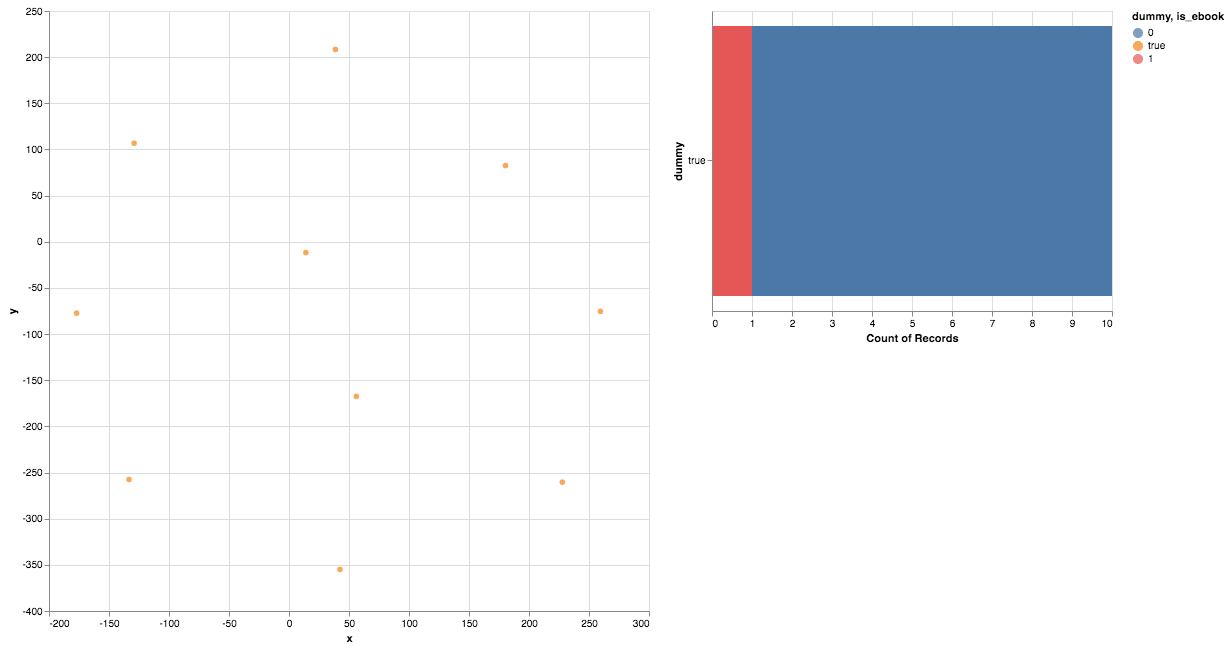

In [55]:
mask = list(neighbors_df.sort_values(['cosine score'], ascending=False)[:10].book_id.values)
neighbor_books_vis = books.iloc[mask]
neighbor_model_book_emb_vis = model_reg.embeddings['book_id'][mask]
tsne_book_embeddings(neighbor_model_book_emb_vis, neighbor_books_vis)